# SimEc and noisy input data

Previously, we've demonstrated, that SimEc can easily handle missing values in the target matrix. Here, we want to investigate how the performance of a SimEc is impacted by noise in the input feature vectors. We distinguish between noise added to the original feature vectors (i.e. noisy measurements) and feature vectors extended by several dimensions only containing noise (i.e. "big data" scenarios, where too many things were measured that are not relevant to the task). Furthermore, we experiment with random noise as well as correlated noise. 

The SimEc is always trained with the more or less noisy feature vectors as input and the original similarity matrix as targets (both for a linear kernel and a class based similarity matrix). As a reference, we provide the eigendecomposition of the similarity matrix and for the linear kernel also the kernel PCA solution, which acts on only the noisy feature vectors as input and computes a linear kernel from these.

Even though kPCA can handle moderate amounts of noise fairly well, the performance nevertheless decreases significantly for larger levels of noise, especially if the noise is correlated. SimEc on the other hand succeeds in filtering out the noise.

Take home message: If you have feature vectors and a similarity matrix and you don't know how/if the similarity matrix was computed from these feature vectors, use a SimEc (or some other method that takes into account both pieces of information, e.g., compute the eigendecomposition of the similarity matrix and then train a separate regression model to learn the mapping from the feature vectors to the embedding space).

In [1]:
from __future__ import unicode_literals, division, print_function, absolute_import
from builtins import range
import numpy as np
np.random.seed(28)
import matplotlib.pyplot as plt
from sklearn.decomposition import KernelPCA
from sklearn.datasets import fetch_mldata
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
tf.set_random_seed(28)
import keras

from simec import SimilarityEncoder
from utils import center_K, check_similarity_match
from utils_plotting import get_colors

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
# load digits
mnist = fetch_mldata('MNIST original', data_home='data')
X = mnist.data/255.  # normalize to 0-1
y = np.array(mnist.target, dtype=int)
# subsample 5000 random data points
np.random.seed(42)
n_samples = 5000
n_targets = 5000
rnd_idx = np.random.permutation(X.shape[0])[:n_samples]
X, y = X[rnd_idx,:], y[rnd_idx]
# scale
ss = StandardScaler(with_std=False)
X = ss.fit_transform(X)
x_std = np.std(X)
# compute linear kernel
print("linear similarities")
K_lin = center_K(np.dot(X, X.T))
# # optimal error for linear kernel
kpca = KernelPCA(n_components=10, kernel='linear')
mse_lk_ed = check_similarity_match(kpca.fit_transform(X), K_lin)[0]
# class based similarities
print("class based similarities")
Y = np.tile(y, (len(y), 1))
S = center_K(np.array(Y==Y.T, dtype=int))
# ev embedding based on class based similarities
D, V = np.linalg.eig(S)
D1, V1 = D[np.argsort(D)[::-1]], V[:,np.argsort(D)[::-1]]
X_embed = np.dot(V1.real, np.diag(np.sqrt(np.abs(D1.real))))[:,:7]
# optimal error for class based sim
mse_class_ed = check_similarity_match(X_embed, S)[0]

linear similarities
class based similarities


### Add random noise to input

noise_level: 0.0
mse lin kpca: 11.04889
Epoch 1/25
5000/5000 [==============================] - 3s 696us/step - loss: 930.3301
Epoch 2/25
5000/5000 [==============================] - 2s 436us/step - loss: 688.4804
Epoch 3/25
5000/5000 [==============================] - 2s 433us/step - loss: 427.1292
Epoch 4/25
5000/5000 [==============================] - 2s 434us/step - loss: 282.0368
Epoch 5/25
5000/5000 [==============================] - 2s 433us/step - loss: 204.1133
Epoch 6/25
5000/5000 [==============================] - 2s 434us/step - loss: 162.8804
Epoch 7/25
5000/5000 [==============================] - 2s 431us/step - loss: 142.1756
Epoch 8/25
5000/5000 [==============================] - 2s 437us/step - loss: 132.8677
Epoch 9/25
5000/5000 [==============================] - 2s 437us/step - loss: 128.8529
Epoch 10/25
5000/5000 [==============================] - 2s 439us/step - loss: 126.9625
Epoch 11/25
5000/5000 [==============================] - 2s 438us/step - loss: 125.9327
E

5000/5000 [==============================] - 2s 466us/step - loss: 0.0427
Epoch 9/25
5000/5000 [==============================] - 2s 465us/step - loss: 0.0397
Epoch 10/25
5000/5000 [==============================] - 2s 465us/step - loss: 0.0374
Epoch 11/25
5000/5000 [==============================] - 2s 465us/step - loss: 0.0353
Epoch 12/25
5000/5000 [==============================] - 2s 463us/step - loss: 0.0338
Epoch 13/25
5000/5000 [==============================] - 2s 465us/step - loss: 0.0323
Epoch 14/25
5000/5000 [==============================] - 2s 464us/step - loss: 0.0313
Epoch 15/25
5000/5000 [==============================] - 2s 462us/step - loss: 0.0307
Epoch 16/25
5000/5000 [==============================] - 2s 464us/step - loss: 0.0301
Epoch 17/25
5000/5000 [==============================] - 2s 463us/step - loss: 0.0297
Epoch 18/25
5000/5000 [==============================] - 2s 467us/step - loss: 0.0292
Epoch 19/25
5000/5000 [==============================] - 2s 465us/s

Text(0,0.5,u'Mean Squared Error of $\\hat{S}$')

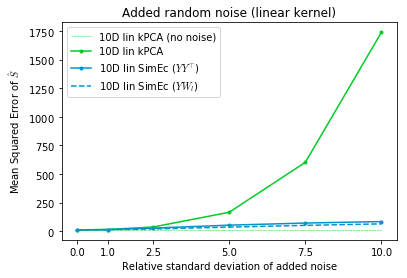

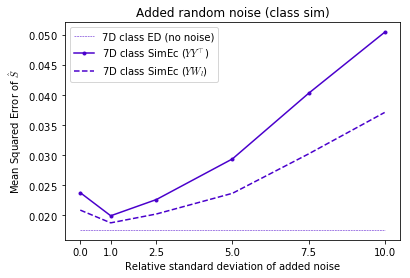

In [3]:
np.random.seed(15)
noise_levels = [0., 1., 2.5, 5., 7.5, 10.]
mse_lin_kpca = []
mse_lin_simec = []
mse_class_simec = []
mse_lin_simec_pred = []
mse_class_simec_pred = []
noise_train = np.random.randn(*X.shape)
noise_train = x_std*noise_train/np.std(noise_train)
for noise_level in noise_levels:
    print("noise_level: %.1f" % noise_level)
    # add random noise to X
    X_noisy = X + noise_level*noise_train
    # lin kpca
    kpca = KernelPCA(n_components=10, kernel='linear')
    mse_lin_kpca.append(check_similarity_match(kpca.fit_transform(X_noisy), K_lin)[0])
    print("mse lin kpca: %.5f" % mse_lin_kpca[-1])
    # lin simec
    simec = SimilarityEncoder(X_noisy.shape[1], 10, n_targets, s_ll_reg=10., S_ll=K_lin[:n_targets,:n_targets],
                              l2_reg_emb=0.001, l2_reg_out=0.00001, opt=keras.optimizers.Adamax(lr=0.005))
    simec.fit(X_noisy, K_lin[:, :n_targets])
    mse_lin_simec.append(check_similarity_match(simec.transform(X_noisy), K_lin)[0])
    print("mse lin simec: %.5f" % mse_lin_simec[-1])
    mse_lin_simec_pred.append(check_similarity_match(simec.predict(X_noisy), K_lin, X_embed_is_S_approx=True)[0])
    print("mse lin simec pred: %.5f" % mse_lin_simec_pred[-1])
    # class simec
    simec = SimilarityEncoder(X_noisy.shape[1], 7, n_targets, hidden_layers=[(25, 'tanh'), (25, 'tanh')],
                              s_ll_reg=0.1, S_ll=S[:n_targets,:n_targets], orth_reg=0.00001, l2_reg=0.,
                              l2_reg_emb=0.00001, l2_reg_out=0.0000001, opt=keras.optimizers.Adamax(lr=0.01))
    simec.fit(X_noisy, S[:, :n_targets])
    mse_class_simec.append(check_similarity_match(simec.transform(X_noisy), S)[0])
    print("mse class simec: %.5f" % mse_class_simec[-1])
    mse_class_simec_pred.append(check_similarity_match(simec.predict(X_noisy), S, X_embed_is_S_approx=True)[0])
    print("mse class simec pred: %.5f" % mse_class_simec_pred[-1])
keras.backend.clear_session()
print("mse_lin_kpca=", mse_lin_kpca)
print("mse_lin_simec=", mse_lin_simec)
print("mse_class_simec=", mse_class_simec)
print("mse_lin_simec_pred=", mse_lin_simec_pred)
print("mse_class_simec_pred=", mse_class_simec_pred)
colors = get_colors(10)
plt.figure();
plt.plot([0, noise_levels[-1]], [mse_lk_ed, mse_lk_ed], '--', c=colors[4], linewidth=0.5, label='10D lin kPCA (no noise)');
plt.plot(noise_levels, mse_lin_kpca, '-o', markersize=3, c=colors[4], label='10D lin kPCA');
plt.plot(noise_levels, mse_lin_simec, '-o', markersize=3, c=colors[6], label='10D lin SimEc ($YY^{\\top}$)');
plt.plot(noise_levels, mse_lin_simec_pred, '--', markersize=3, c=colors[6], label='10D lin SimEc ($YW_l$)');
plt.legend(loc=0);
plt.title('Added random noise (linear kernel)');
plt.xticks(noise_levels, noise_levels);
plt.xlabel('Relative standard deviation of added noise')
plt.ylabel('Mean Squared Error of $\hat{S}$')
plt.figure();
plt.plot([0, noise_levels[-1]], [mse_class_ed, mse_class_ed], '--', c=colors[8], linewidth=0.5, label='7D class ED (no noise)');
plt.plot(noise_levels, mse_class_simec, '-o', markersize=3, c=colors[8], label='7D class SimEc ($YY^{\\top}$)');
plt.plot(noise_levels, mse_class_simec_pred, '--', markersize=3, c=colors[8], label='7D class SimEc ($YW_l$)');
plt.legend(loc=0);
plt.title('Added random noise (class sim)');
plt.xticks(noise_levels, noise_levels);
plt.xlabel('Relative standard deviation of added noise')
plt.ylabel('Mean Squared Error of $\hat{S}$');

### Add correlated noise to input data

In [4]:
np.random.seed(15)
noise_levels = [0., 1., 2.5, 5., 7.5, 10.]
mse_lin_kpca = []
mse_lin_simec = []
mse_class_simec = []
mse_lin_simec_pred = []
mse_class_simec_pred = []
# generate random covariance matrix
cov = np.random.randn(X.shape[1], X.shape[1])
cov = 0.33*(cov + cov.T + np.eye(X.shape[1]))
# make sure it's positive semidefinite
D, V = np.linalg.eig(cov)
D, V = D[np.argsort(D)[::-1]], V[:, np.argsort(D)[::-1]]
cov_embed = np.dot(V, np.diag(np.sqrt(np.abs(D))))
cov = np.dot(cov_embed[:,:100], cov_embed[:,:100].T)
# generate correlated noise data
noise_train = np.random.multivariate_normal(np.zeros(X.shape[1]), cov, X.shape[0])
noise_train = x_std*noise_train/np.std(noise_train)
for noise_level in noise_levels:
    print("noise_level: %.1f" % noise_level)
    # add random noise to X and X_test
    X_noisy = X + noise_level*noise_train
    # lin kpca
    kpca = KernelPCA(n_components=10, kernel='linear')
    mse_lin_kpca.append(check_similarity_match(kpca.fit_transform(X_noisy), K_lin)[0])
    print("mse lin kpca: %.5f" % mse_lin_kpca[-1])
    # lin simec
    simec = SimilarityEncoder(X_noisy.shape[1], 10, n_targets, s_ll_reg=10., S_ll=K_lin[:n_targets,:n_targets],
                              l2_reg_emb=0.001, l2_reg_out=0.00001, opt=keras.optimizers.Adamax(lr=0.005))
    simec.fit(X_noisy, K_lin[:, :n_targets])
    mse_lin_simec.append(check_similarity_match(simec.transform(X_noisy), K_lin)[0])
    print("mse lin simec: %.5f" % mse_lin_simec[-1])
    mse_lin_simec_pred.append(check_similarity_match(simec.predict(X_noisy), K_lin, X_embed_is_S_approx=True)[0])
    print("mse lin simec pred: %.5f" % mse_lin_simec_pred[-1])
    # class simec
    simec = SimilarityEncoder(X_noisy.shape[1], 7, n_targets, hidden_layers=[(25, 'tanh'), (25, 'tanh')],
                              s_ll_reg=0.1, S_ll=S[:n_targets,:n_targets], orth_reg=0.00001, l2_reg=0.,
                              l2_reg_emb=0.00001, l2_reg_out=0.0000001, opt=keras.optimizers.Adamax(lr=0.01))
    simec.fit(X_noisy, S[:, :n_targets])
    mse_class_simec.append(check_similarity_match(simec.transform(X_noisy), S)[0])
    print("mse class simec: %.5f" % mse_class_simec[-1])
    mse_class_simec_pred.append(check_similarity_match(simec.predict(X_noisy), S, X_embed_is_S_approx=True)[0])
    print("mse class simec pred: %.5f" % mse_class_simec_pred[-1])
keras.backend.clear_session()
print("mse_lin_kpca=", mse_lin_kpca)
print("mse_lin_simec=", mse_lin_simec)
print("mse_class_simec=", mse_class_simec)
print("mse_lin_simec_pred=", mse_lin_simec_pred)
print("mse_class_simec_pred=", mse_class_simec_pred)
colors = get_colors(10)
plt.figure();
plt.plot([0, noise_levels[-1]], [mse_lk_ed, mse_lk_ed], '--', c=colors[4], linewidth=0.5, label='10D lin kPCA (no noise)');
plt.plot(noise_levels, mse_lin_kpca, '-o', markersize=3, c=colors[4], label='10D lin kPCA');
plt.plot(noise_levels, mse_lin_simec, '-o', markersize=3, c=colors[6], label='10D lin SimEc ($YY^{\\top}$)');
plt.plot(noise_levels, mse_lin_simec_pred, '--', markersize=3, c=colors[6], label='10D lin SimEc ($YW_l$)');
plt.legend(loc=0);
plt.title('Added correlated noise (linear kernel)');
plt.xticks(noise_levels, noise_levels);
plt.xlabel('Relative standard deviation of added noise')
plt.ylabel('Mean Squared Error of $\hat{S}$')
plt.figure();
plt.plot([0, noise_levels[-1]], [mse_class_ed, mse_class_ed], '--', c=colors[8], linewidth=0.5, label='7D class ED (no noise)');
plt.plot(noise_levels, mse_class_simec, '-o', markersize=3, c=colors[8], label='7D class SimEc ($YY^{\\top}$)');
plt.plot(noise_levels, mse_class_simec_pred, '--', markersize=3, c=colors[8], label='7D class SimEc ($YW_l$)');
plt.legend(loc=0);
plt.title('Added correlated noise (class sim)');
plt.xticks(noise_levels, noise_levels);
plt.xlabel('Relative standard deviation of added noise')
plt.ylabel('Mean Squared Error of $\hat{S}$');

noise_level: 0.0
mse lin kpca: 11.04889
Epoch 1/25
5000/5000 [==============================] - 3s 695us/step - loss: 929.8280
Epoch 2/25
5000/5000 [==============================] - 2s 438us/step - loss: 686.2777
Epoch 3/25
5000/5000 [==============================] - 2s 433us/step - loss: 415.4617
Epoch 4/25
5000/5000 [==============================] - 2s 433us/step - loss: 271.6651
Epoch 5/25
5000/5000 [==============================] - 2s 437us/step - loss: 193.2714
Epoch 6/25
5000/5000 [==============================] - 2s 440us/step - loss: 152.9164
Epoch 7/25
5000/5000 [==============================] - 2s 438us/step - loss: 135.4061
Epoch 8/25
5000/5000 [==============================] - 2s 439us/step - loss: 128.8300
Epoch 9/25
5000/5000 [==============================] - 2s 438us/step - loss: 126.1605
Epoch 10/25
5000/5000 [==============================] - 2s 441us/step - loss: 124.8358
Epoch 11/25
5000/5000 [==============================] - 2s 442us/step - loss: 124.0413
E

5000/5000 [==============================] - 2s 468us/step - loss: 0.0430
Epoch 9/25
5000/5000 [==============================] - 2s 463us/step - loss: 0.0403
Epoch 10/25
5000/5000 [==============================] - 2s 463us/step - loss: 0.0380
Epoch 11/25
5000/5000 [==============================] - 2s 472us/step - loss: 0.0365
Epoch 12/25
5000/5000 [==============================] - 2s 459us/step - loss: 0.0352
Epoch 13/25
5000/5000 [==============================] - 2s 465us/step - loss: 0.0343
Epoch 14/25
5000/5000 [==============================] - 2s 461us/step - loss: 0.0333
Epoch 15/25
5000/5000 [==============================] - 2s 463us/step - loss: 0.0328
Epoch 16/25
5000/5000 [==============================] - 2s 464us/step - loss: 0.0322
Epoch 17/25
5000/5000 [==============================] - 2s 469us/step - loss: 0.0322
Epoch 18/25
5000/5000 [==============================] - 2s 464us/step - loss: 0.0320
Epoch 19/25
5000/5000 [==============================] - 2s 466us/s

Text(0,0.5,u'Mean Squared Error of $\\hat{S}$')

### Add additional input dimensions with random noise

In [5]:
np.random.seed(15)
noise_levels = [0, X.shape[1], 2*X.shape[1], 4*X.shape[1], 6*X.shape[1], 8*X.shape[1], 10*X.shape[1]]
mse_lin_kpca = []
mse_lin_simec = []
mse_class_simec = []
mse_lin_simec_pred = []
mse_class_simec_pred = []
noise_train = np.random.randn(X.shape[0], max(noise_levels))
noise_train = x_std*noise_train/np.std(noise_train)
for noise_level in noise_levels:
    print("noise dimensions: %i" % noise_level)
    # add random noise as additional feature dimensions
    X_noisy = np.hstack((X, noise_train[:,:noise_level]))
    # lin kpca
    kpca = KernelPCA(n_components=10, kernel='linear')
    mse_lin_kpca.append(check_similarity_match(kpca.fit_transform(X_noisy), K_lin)[0])
    print("mse lin kpca: %.5f" % mse_lin_kpca[-1])
    # lin simec
    simec = SimilarityEncoder(X_noisy.shape[1], 10, n_targets, s_ll_reg=10., S_ll=K_lin[:n_targets,:n_targets],
                              l2_reg_emb=0.001, l2_reg_out=0.00001, opt=keras.optimizers.Adamax(lr=0.005 if noise_level <= 4*X.shape[1] else 0.001))
    simec.fit(X_noisy, K_lin[:, :n_targets])
    mse_lin_simec.append(check_similarity_match(simec.transform(X_noisy), K_lin)[0])
    print("mse lin simec: %.5f" % mse_lin_simec[-1])
    mse_lin_simec_pred.append(check_similarity_match(simec.predict(X_noisy), K_lin, X_embed_is_S_approx=True)[0])
    print("mse lin simec pred: %.5f" % mse_lin_simec_pred[-1])
    # class simec
    simec = SimilarityEncoder(X_noisy.shape[1], 7, n_targets, hidden_layers=[(25, 'tanh'), (25, 'tanh')],
                              s_ll_reg=0.1, S_ll=S[:n_targets,:n_targets], orth_reg=0.00001, l2_reg=0.,
                              l2_reg_emb=0.00001, l2_reg_out=0.0000001, opt=keras.optimizers.Adamax(lr=0.01 if noise_level < 4*X.shape[1] else 0.005))
    simec.fit(X_noisy, S[:, :n_targets])
    mse_class_simec.append(check_similarity_match(simec.transform(X_noisy), S)[0])
    print("mse class simec: %.5f" % mse_class_simec[-1])
    mse_class_simec_pred.append(check_similarity_match(simec.predict(X_noisy), S, X_embed_is_S_approx=True)[0])
    print("mse class simec pred: %.5f" % mse_class_simec_pred[-1])
keras.backend.clear_session()
print("mse_lin_kpca=", mse_lin_kpca)
print("mse_lin_simec=", mse_lin_simec)
print("mse_class_simec=", mse_class_simec)
print("mse_lin_simec_pred=", mse_lin_simec_pred)
print("mse_class_simec_pred=", mse_class_simec_pred)
colors = get_colors(10)
plt.figure();
plt.plot([0, noise_levels[-1]], [mse_lk_ed, mse_lk_ed], '--', c=colors[4], linewidth=0.5, label='10D lin kPCA (no noise)');
plt.plot(noise_levels, mse_lin_kpca, '-o', markersize=3, c=colors[4], label='10D lin kPCA');
plt.plot(noise_levels, mse_lin_simec, '-o', markersize=3, c=colors[6], label='10D lin SimEc ($YY^{\\top}$)');
plt.plot(noise_levels, mse_lin_simec_pred, '--', markersize=3, c=colors[6], label='10D lin SimEc ($YW_l$)');
plt.legend(loc=0);
plt.title('Added dimensions with random noise (linear kernel)');
plt.xticks(noise_levels, [0, '$D$', '$2\\times D$', '$4\\times D$', '$6\\times D$', '$8\\times D$', '$10\\times D$']);
plt.xlabel('Additional noise dimensions (where $D = 784$)')
plt.ylabel('Mean Squared Error of $\hat{S}$')
plt.figure();
plt.plot([0, noise_levels[-1]], [mse_class_ed, mse_class_ed], '--', c=colors[8], linewidth=0.5, label='7D class ED (no noise)');
plt.plot(noise_levels, mse_class_simec, '-o', markersize=3, c=colors[8], label='7D class SimEc ($YY^{\\top}$)');
plt.plot(noise_levels, mse_class_simec_pred, '--', markersize=3, c=colors[8], label='7D class SimEc ($YW_l$)');
plt.legend(loc=0);
plt.title('Added dimensions with random noise (class sim)');
plt.xticks(noise_levels, [0, '$D$', '$2\\times D$', '$4\\times D$', '$6\\times D$', '$8\\times D$', '$10\\times D$']);
plt.xlabel('Additional noise dimensions (where $D = 784$)');
plt.ylabel('Mean Squared Error of $\hat{S}$');

noise dimensions: 0
mse lin kpca: 11.04889
Epoch 1/25
5000/5000 [==============================] - 4s 742us/step - loss: 930.5728
Epoch 2/25
5000/5000 [==============================] - 2s 437us/step - loss: 689.9882
Epoch 3/25
5000/5000 [==============================] - 2s 438us/step - loss: 415.4672
Epoch 4/25
5000/5000 [==============================] - 2s 437us/step - loss: 271.9111
Epoch 5/25
5000/5000 [==============================] - 2s 454us/step - loss: 200.3961
Epoch 6/25
5000/5000 [==============================] - 2s 463us/step - loss: 162.3277
Epoch 7/25
5000/5000 [==============================] - 2s 448us/step - loss: 139.2309
Epoch 8/25
5000/5000 [==============================] - 2s 450us/step - loss: 130.0155
Epoch 9/25
5000/5000 [==============================] - 2s 462us/step - loss: 126.2490
Epoch 10/25
5000/5000 [==============================] - 2s 444us/step - loss: 124.4264
Epoch 11/25
5000/5000 [==============================] - 2s 439us/step - loss: 123.525

5000/5000 [==============================] - 2s 474us/step - loss: 0.0265
Epoch 9/25
5000/5000 [==============================] - 2s 476us/step - loss: 0.0258
Epoch 10/25
5000/5000 [==============================] - 2s 476us/step - loss: 0.0251
Epoch 11/25
5000/5000 [==============================] - 2s 478us/step - loss: 0.0242
Epoch 12/25
5000/5000 [==============================] - 2s 474us/step - loss: 0.0231
Epoch 13/25
5000/5000 [==============================] - 2s 475us/step - loss: 0.0221
Epoch 14/25
5000/5000 [==============================] - 2s 478us/step - loss: 0.0213
Epoch 15/25
5000/5000 [==============================] - 2s 471us/step - loss: 0.0208
Epoch 16/25
5000/5000 [==============================] - 2s 474us/step - loss: 0.0204
Epoch 17/25
5000/5000 [==============================] - 2s 473us/step - loss: 0.0202
Epoch 18/25
5000/5000 [==============================] - 2s 474us/step - loss: 0.0201
Epoch 19/25
5000/5000 [==============================] - 2s 473us/s

Text(0,0.5,u'Mean Squared Error of $\\hat{S}$')

### Add additional input dimensions with correlated noise

noise dimensions: 0
mse lin kpca: 11.04889
Epoch 1/25
5000/5000 [==============================] - 4s 703us/step - loss: 928.9582
Epoch 2/25
5000/5000 [==============================] - 2s 438us/step - loss: 680.2921
Epoch 3/25
5000/5000 [==============================] - 2s 438us/step - loss: 430.4882
Epoch 4/25
5000/5000 [==============================] - 2s 437us/step - loss: 274.2560
Epoch 5/25
5000/5000 [==============================] - 2s 439us/step - loss: 191.4925
Epoch 6/25
5000/5000 [==============================] - 2s 439us/step - loss: 155.5927
Epoch 7/25
5000/5000 [==============================] - 2s 444us/step - loss: 141.2990
Epoch 8/25
5000/5000 [==============================] - 2s 439us/step - loss: 134.9620
Epoch 9/25
5000/5000 [==============================] - 2s 441us/step - loss: 131.7087
Epoch 10/25
5000/5000 [==============================] - 2s 441us/step - loss: 129.4775
Epoch 11/25
5000/5000 [==============================] - 2s 442us/step - loss: 127.511

5000/5000 [==============================] - 2s 478us/step - loss: 0.0327
Epoch 9/25
5000/5000 [==============================] - 2s 477us/step - loss: 0.0312
Epoch 10/25
5000/5000 [==============================] - 2s 469us/step - loss: 0.0297
Epoch 11/25
5000/5000 [==============================] - 2s 475us/step - loss: 0.0283
Epoch 12/25
5000/5000 [==============================] - 2s 471us/step - loss: 0.0277
Epoch 13/25
5000/5000 [==============================] - 2s 470us/step - loss: 0.0270
Epoch 14/25
5000/5000 [==============================] - 2s 472us/step - loss: 0.0267
Epoch 15/25
5000/5000 [==============================] - 2s 471us/step - loss: 0.0263
Epoch 16/25
5000/5000 [==============================] - 2s 477us/step - loss: 0.0260
Epoch 17/25
5000/5000 [==============================] - 2s 472us/step - loss: 0.0259
Epoch 18/25
5000/5000 [==============================] - 2s 470us/step - loss: 0.0256
Epoch 19/25
5000/5000 [==============================] - 2s 473us/s

Text(0,0.5,u'Mean Squared Error of $\\hat{S}$')

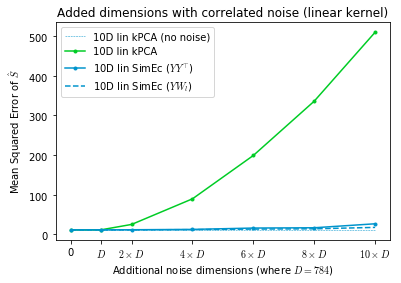

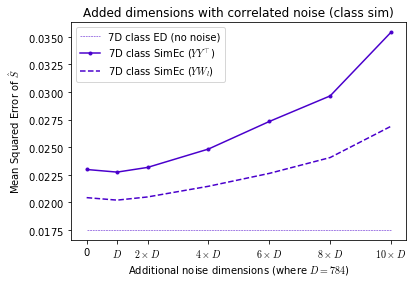

In [6]:
np.random.seed(15)
noise_levels = [0, X.shape[1], 2*X.shape[1], 4*X.shape[1], 6*X.shape[1], 8*X.shape[1], 10*X.shape[1]]
mse_lin_kpca = []
mse_lin_simec = []
mse_class_simec = []
mse_lin_simec_pred = []
mse_class_simec_pred = []
# generate random covariance matrix
cov = np.random.randn(max(noise_levels), max(noise_levels))
cov = 0.33*(cov + cov.T + np.eye(max(noise_levels)))
# make sure it's positive semidefinite
D, V = np.linalg.eig(cov)
D, V = D[np.argsort(D)[::-1]], V[:, np.argsort(D)[::-1]]
cov_embed = np.dot(V, np.diag(np.sqrt(np.abs(D))))
cov = np.dot(cov_embed[:,:100], cov_embed[:,:100].T)
# generate correlated noise data
noise_train = np.random.multivariate_normal(np.zeros(max(noise_levels)), cov, X.shape[0])
noise_train = x_std*noise_train/np.std(noise_train)
for noise_level in noise_levels:
    print("noise dimensions: %i" % noise_level)
    # add random noise as additional feature dimensions
    X_noisy = np.hstack((X, noise_train[:,:noise_level]))
    # lin kpca
    kpca = KernelPCA(n_components=10, kernel='linear')
    mse_lin_kpca.append(check_similarity_match(kpca.fit_transform(X_noisy), K_lin)[0])
    print("mse lin kpca: %.5f" % mse_lin_kpca[-1])
    # lin simec
    simec = SimilarityEncoder(X_noisy.shape[1], 10, n_targets, s_ll_reg=10., S_ll=K_lin[:n_targets,:n_targets],
                              l2_reg_emb=0.001, l2_reg_out=0.00001, opt=keras.optimizers.Adamax(lr=0.005))
    simec.fit(X_noisy, K_lin[:, :n_targets])
    mse_lin_simec.append(check_similarity_match(simec.transform(X_noisy), K_lin)[0])
    print("mse lin simec: %.5f" % mse_lin_simec[-1])
    mse_lin_simec_pred.append(check_similarity_match(simec.predict(X_noisy), K_lin, X_embed_is_S_approx=True)[0])
    print("mse lin simec pred: %.5f" % mse_lin_simec_pred[-1])
    # class simec
    simec = SimilarityEncoder(X_noisy.shape[1], 7, n_targets, hidden_layers=[(25, 'tanh'), (25, 'tanh')],
                              s_ll_reg=0.1, S_ll=S[:n_targets,:n_targets], orth_reg=0.00001, l2_reg=0.,
                              l2_reg_emb=0.00001, l2_reg_out=0.0000001, opt=keras.optimizers.Adamax(lr=0.01))
    simec.fit(X_noisy, S[:, :n_targets])
    mse_class_simec.append(check_similarity_match(simec.transform(X_noisy), S)[0])
    print("mse class simec: %.5f" % mse_class_simec[-1])
    mse_class_simec_pred.append(check_similarity_match(simec.predict(X_noisy), S, X_embed_is_S_approx=True)[0])
    print("mse class simec pred: %.5f" % mse_class_simec_pred[-1])
keras.backend.clear_session()
print("mse_lin_kpca=", mse_lin_kpca)
print("mse_lin_simec=", mse_lin_simec)
print("mse_class_simec=", mse_class_simec)
print("mse_lin_simec_pred=", mse_lin_simec_pred)
print("mse_class_simec_pred=", mse_class_simec_pred)
colors = get_colors(10)
plt.figure();
plt.plot([0, noise_levels[-1]], [mse_lk_ed, mse_lk_ed], '--', c=colors[4], linewidth=0.5, label='10D lin kPCA (no noise)');
plt.plot(noise_levels, mse_lin_kpca, '-o', markersize=3, c=colors[4], label='10D lin kPCA');
plt.plot(noise_levels, mse_lin_simec, '-o', markersize=3, c=colors[6], label='10D lin SimEc ($YY^{\\top}$)');
plt.plot(noise_levels, mse_lin_simec_pred, '--', markersize=3, c=colors[6], label='10D lin SimEc ($YW_l$)');
plt.legend(loc=0);
plt.title('Added dimensions with correlated noise (linear kernel)');
plt.xticks(noise_levels, [0, '$D$', '$2\\times D$', '$4\\times D$', '$6\\times D$', '$8\\times D$', '$10\\times D$']);
plt.xlabel('Additional noise dimensions (where $D = 784$)')
plt.ylabel('Mean Squared Error of $\hat{S}$')
plt.figure();
plt.plot([0, noise_levels[-1]], [mse_class_ed, mse_class_ed], '--', c=colors[8], linewidth=0.5, label='7D class ED (no noise)');
plt.plot(noise_levels, mse_class_simec, '-o', markersize=3, c=colors[8], label='7D class SimEc ($YY^{\\top}$)');
plt.plot(noise_levels, mse_class_simec_pred, '--', markersize=3, c=colors[8], label='7D class SimEc ($YW_l$)');
plt.legend(loc=0);
plt.title('Added dimensions with correlated noise (class sim)');
plt.xticks(noise_levels, [0, '$D$', '$2\\times D$', '$4\\times D$', '$6\\times D$', '$8\\times D$', '$10\\times D$']);
plt.xlabel('Additional noise dimensions (where $D = 784$)')
plt.ylabel('Mean Squared Error of $\hat{S}$');